### Esercitazione 10 - Donchian Channels
#### Argomenti

* indicatore Donchian Channels
* implementazione di grafici custum per la rappresentazione dell'indicatore Donchian Channels
* implementazione di una semplice strategia basata su Donchian Channels

I canali Donchian sono tre linee generate da calcoli di media mobile che comprendono un indicatore
formato da bande superiori e inferiori attorno a una fascia media o mediana. La fascia superiore indica il prezzo più alto di uno strumento finanziario su N periodi, mentre la fascia inferiore indica il prezzo più basso di uno strumento finanziario su N periodi.    
L'area compresa tra la fascia superiore e quella inferiore rappresenta il Canale di Donchian.    
    
Le seguenti formule permettono di calcolare il Donchian Channel:    
* UC = Upper Channel, massimo High negli ultimi N periodi    
* LC = Lower Channel, minimo Low negli ultimi N periodi    
* MC = ((UC + LC) / 2)    
    
Questo indicatore costruisce una mappa visiva del prezzo nel tempo, in modo simile a quanto
fanno le bande di Bollinger, indicando l'entità del rialzo e del ribasso per il periodo scelto.    
La linea superiore identifica l'entità dell'energia rialzista, evidenziando il prezzo più alto
raggiunto per il periodo La linea centrale identifica il prezzo di ritorno medio per
il periodo selezionato.    
La linea di fondo identifica l'entità dell'energia ribassista, evidenziando il prezzo più basso
raggiunto per il periodo scelto.

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from collections import deque
import numpy as np

In [36]:
connected = mt5.initialize(login=5776609, server="ActivTrades-Server", password='YDSNcmto')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_H1, 0, 1000))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

In [37]:
def get_donchian_channels(data, period=20):
    data["uc"] = data["high"].rolling(period).max()
    data["lc"] = data["low"].rolling(period).min()
    data["mc"] = (data["uc"] + data["lc"]) / 2
    data = data[period:]
    return data

candles = get_donchian_channels(candles, period=35)

candles.head()

,open,high,low,close,tick_volume,spread,real_volume,uc,lc,mc
time,,,,,,,,,,
2022-08-24 08:00:00,0.99426,0.99508,0.99340,0.99487,3741,5,0,1.00177,0.98995,0.99586
2022-08-24 09:00:00,0.99490,0.99590,0.99439,0.99529,5411,5,0,1.00177,0.98995,0.99586
2022-08-24 10:00:00,0.99529,0.99559,0.99412,0.99457,4301,5,0,1.00177,0.98995,0.99586
2022-08-24 11:00:00,0.99457,0.99581,0.99441,0.99489,4765,5,0,1.00177,0.98995,0.99586
2022-08-24 12:00:00,0.99490,0.99494,0.99161,0.99213,4610,5,0,1.00177,0.98995,0.99586


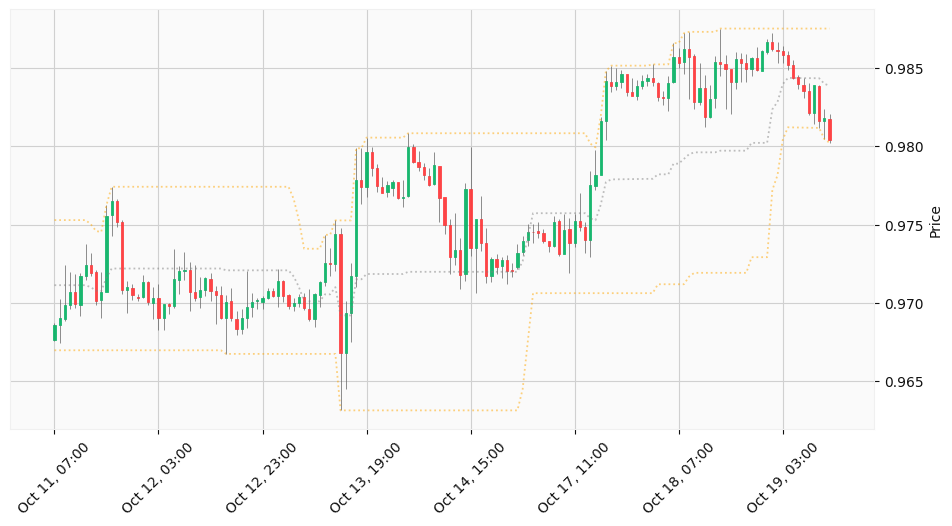

In [38]:
uc_plot = mpf.make_addplot(candles['uc'][-150:], linestyle='dotted', alpha=0.5, color='orange')
mc_plot = mpf.make_addplot(candles['mc'][-150:], linestyle='dotted', alpha=0.5, color='gray')
lc_plot = mpf.make_addplot(candles['lc'][-150:], linestyle='dotted', alpha=0.5, color='orange')
mpf.plot(candles[-150:], addplot=[uc_plot, mc_plot, lc_plot], type='candle', style='yahoo', figsize=(12, 6))

In [39]:
candles['close_1'] = candles['close'].shift(1)
candles['uc_1'] = candles['uc'].shift(1)
candles['mc_1'] = candles['mc'].shift(1)
candles['lc_1'] = candles['lc'].shift(1)

posizione = 0
movimenti = []
for id, c in candles.iterrows():
    if posizione == 0:
        if c.close > c.uc_1:
            posizione = 1
            movimenti.append([c.name, c.close, np.nan, np.nan, 1])
        if c.close < c.lc_1:
            posizione = -1
            movimenti.append([c.name, c.close, np.nan, np.nan, -1])
    else:
        if posizione == 1:
            if c.close < c.lc_1:
                posizione = 0
                m = movimenti[-1]
                m[2] = c.name
                m[3] = c.close
                print(
                    m[0],
                    'buy' if m[-1] == 1 else 'sell',
                    m[1],
                    '-',
                    m[2],
                    'sell' if m[-1] == 1 else 'buy',
                    m[3],
                    '- risultato:',
                    m[3] - m[1] if m[-1] == 1 else m[1] - m[3]
                )
        elif posizione == -1:
            if c.close > c.uc_1:
                posizione = 0
                m = movimenti[-1]
                m[2] = c.name
                m[3] = c.close
                print(
                    m[0],
                    'buy' if m[-1] == 1 else 'sell',
                    m[1],
                    '-',
                    m[2],
                    'sell' if m[-1] == 1 else 'buy',
                    m[3],
                    '- risultato:',
                    m[3] - m[1] if m[-1] == 1 else m[1] - m[3]
                )

if np.isnan(movimenti[-1][3]):
    m = movimenti[-1]
    m[2] = candles.iloc[-1].name
    m[3] = candles.iloc[-1].close
    print(
        m[0],
        'buy' if m[-1] == 1 else 'sell',
        m[1],
        '-',
        m[2],
        'sell' if m[-1] == 1 else 'buy',
        m[3],
        '- risultato:',
        m[3] - m[1] if m[-1] == 1 else m[1] - m[3]
    )

rendimento = 0.
vinte = 0
for m in movimenti:
    risultato = (m[3] - m[1]) * m[4]
    if risultato > 0:
        vinte += 1
    rendimento += risultato

print('rendimento:', rendimento)
print('vinte', vinte, 'su', len(movimenti))

2022-08-25 06:00:00 buy 0.99985 - 2022-08-29 01:00:00 sell 0.99359 - risultato: -0.006260000000000043
2022-08-29 02:00:00 sell 0.99299 - 2022-08-31 17:00:00 buy 1.00627 - risultato: -0.013279999999999959
2022-09-01 16:00:00 sell 0.99316 - 2022-09-07 19:00:00 buy 0.99963 - risultato: -0.006469999999999976
2022-09-07 21:00:00 buy 1.00083 - 2022-09-13 14:00:00 sell 1.00367 - risultato: 0.0028399999999999537
2022-09-13 17:00:00 sell 0.99961 - 2022-09-16 16:00:00 buy 1.00299 - risultato: -0.0033800000000000496
2022-09-21 07:00:00 sell 0.99501 - 2022-09-28 17:00:00 buy 0.96783 - risultato: 0.027179999999999982
2022-09-28 18:00:00 buy 0.97016 - 2022-10-06 15:00:00 sell 0.9829 - risultato: 0.012739999999999974
2022-10-06 17:00:00 sell 0.98045 - 2022-10-11 17:00:00 buy 0.97557 - risultato: 0.0048799999999999955
2022-10-11 18:00:00 buy 0.97648 - 2022-10-19 12:00:00 sell 0.98041 - risultato: 0.003929999999999989
rendimento: 0.022179999999999866
vinte 5 su 9


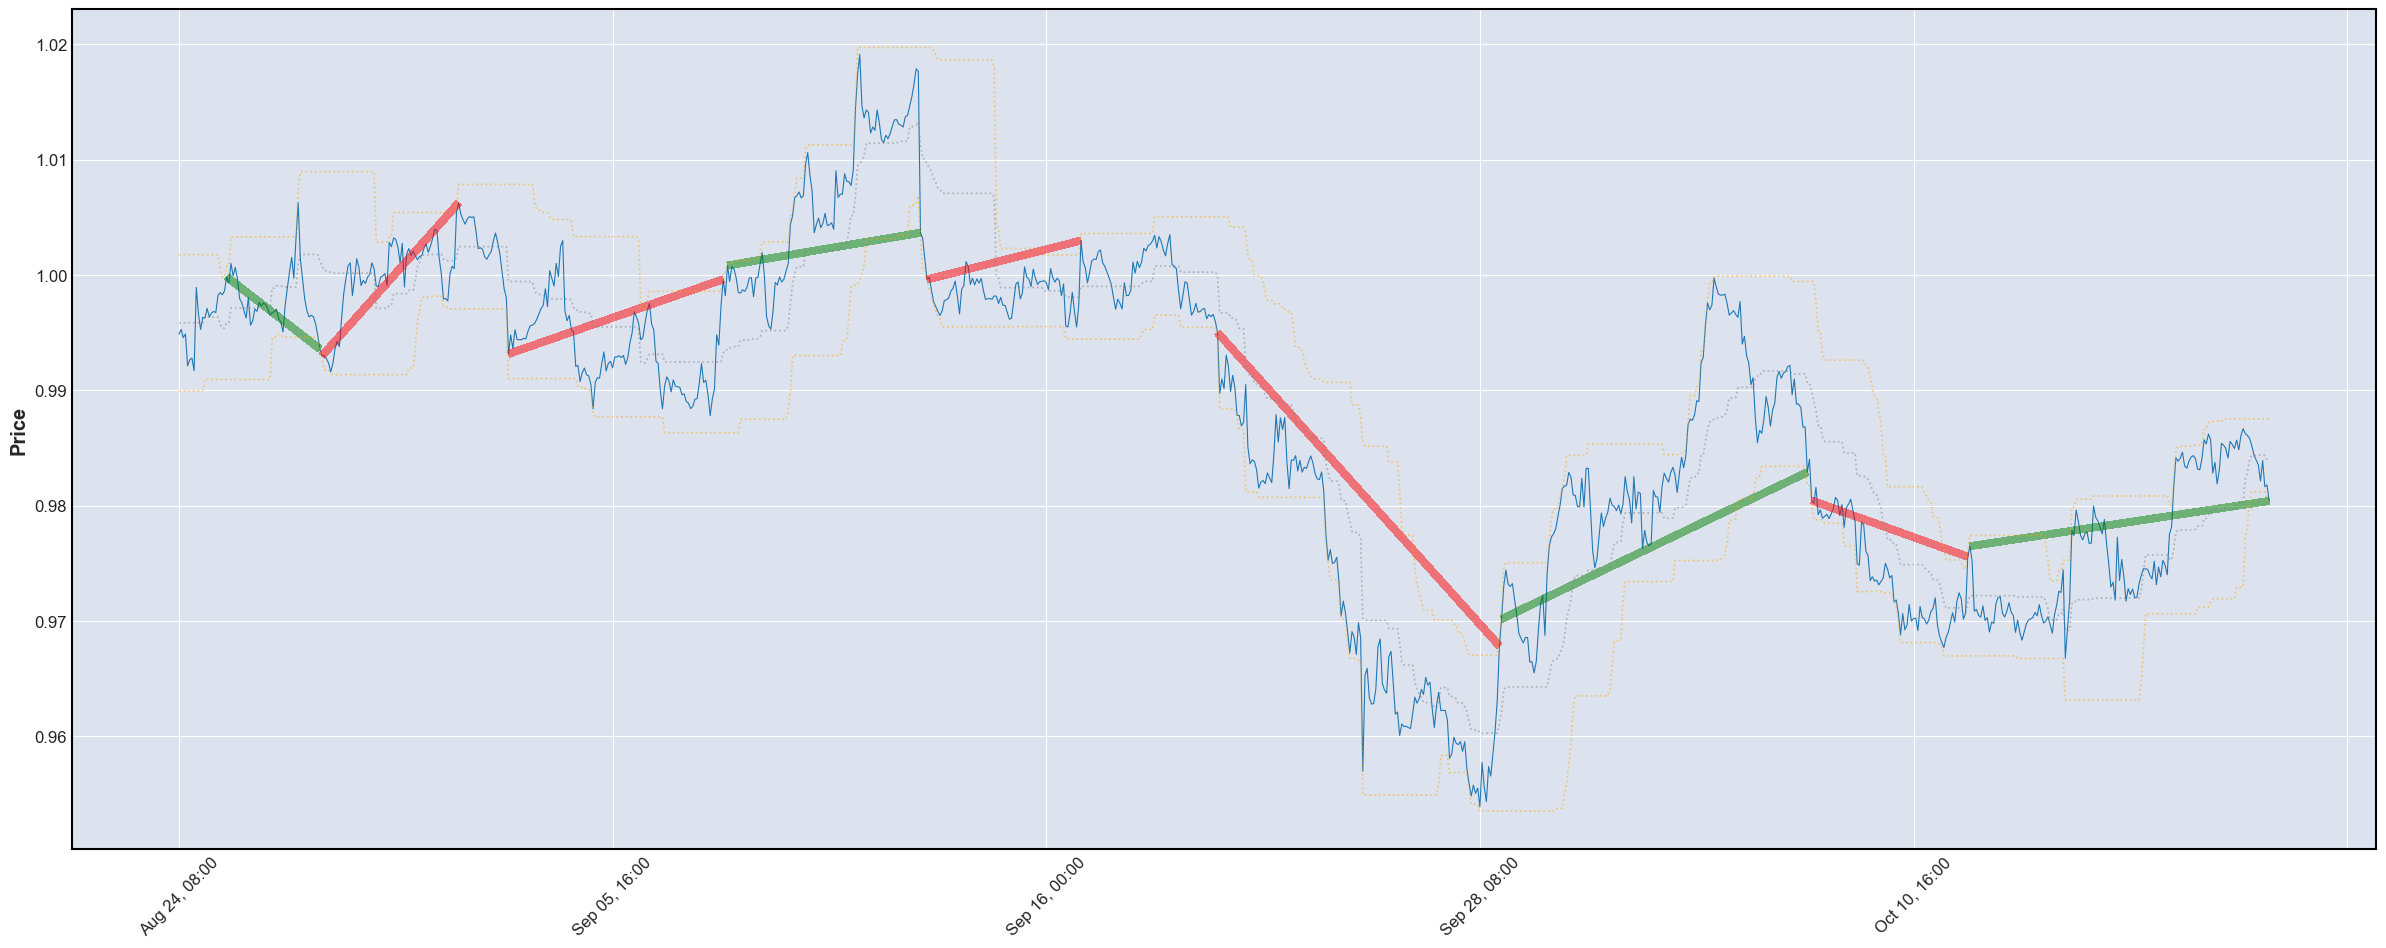

In [40]:
lines = []
colors = []

for m in movimenti:
    lines.append([(m[0], m[1]), (m[2], m[3])])
    if m[-1] == 1:
        colors.append('g')
    else:
        colors.append('r')

uc_plot = mpf.make_addplot(candles['uc'], linestyle='dotted', alpha=0.5, color='orange')
mc_plot = mpf.make_addplot(candles['mc'], linestyle='dotted', alpha=0.5, color='gray')
lc_plot = mpf.make_addplot(candles['lc'], linestyle='dotted', alpha=0.5, color='orange')
mpf.plot(candles, addplot=[uc_plot, mc_plot, lc_plot], alines=dict(alines=lines, colors=colors, linewidths=5, alpha=0.5), figsize=(32, 12), type='line')